In [1]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import subprocess
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import tensorflow as tf
import random
from collections import deque
import traci

# Constants
NUM_PHASES = 4  # Number of traffic light phases
STATE_DIM = 4  # Number of state variables (adjust based on your scenario)
ACTION_DIM = NUM_PHASES  # Number of possible actions (traffic light phases)
GAMMA = 0.9  # Discount factor
# EPSILON_START = 1.0  # Initial exploration rate
EPSILON_MIN = 0.1  # Minimum exploration rate
# EPSILON_DECAY = 0.995  # Decay rate for exploration
ALPHA = 0.0001  # Learning rate
MEMORY_CAPACITY = 10000  # Replay memory capacity
BATCH_SIZE = 32  # Batch size for training
NUM_EPISODES = 100  # Number of training episodes

# Q-network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(STATE_DIM,)),
    tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Target Q-network (used for more stable updates)
target_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(STATE_DIM,)),
    tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
])
target_model.set_weights(model.get_weights())  # Initialize with the same weights
target_model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Replay memory
memory = deque(maxlen=MEMORY_CAPACITY)

# Epsilon for exploration
epsilon = EPSILON_MIN

def get_state():
    """Implement logic to get the current state from SUMO"""
    state = [
        traci.edge.getLastStepHaltingNumber("in"),  # Main road
        traci.edge.getLastStepHaltingNumber("intramp"),  # Ramp
        traci.edge.getLastStepMeanSpeed("in"),  # Main road speed
        traci.edge.getLastStepMeanSpeed("intramp"),  # Ramp speed
    ]
    return np.array(state)

def choose_action(state):
    """Choose an action using epsilon-greedy policy with epsilon decay"""
    if np.random.rand() < epsilon:
        return np.random.randint(ACTION_DIM)  # Exploration: random action
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)  # Exploitation: action with max Q-value

def update_q_network():
    """Update the Q-network by sampling a minibatch from memory and training the model"""
    if len(memory) < BATCH_SIZE:
        return

    minibatch = random.sample(memory, BATCH_SIZE)

    # Extract each part of the minibatch: state, action, reward, next_state, done
    states = np.array([entry[0] for entry in minibatch])
    actions = np.array([entry[1] for entry in minibatch])
    rewards = np.array([entry[2] for entry in minibatch])
    next_states = np.array([entry[3] for entry in minibatch])
    dones = np.array([entry[4] for entry in minibatch])

    # Predict Q-values for states and next states
    q_values = model.predict(states)
    next_q_values = target_model.predict(next_states)

    # Update Q-values based on the Bellman equation
    for i in range(BATCH_SIZE):
        if dones[i]:
            q_values[i, actions[i]] = rewards[i]  # Terminal state
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])  # Non-terminal state

    # Train the model
    model.fit(states, q_values, epochs=1, verbose=0)

def calculate_reward(state, action, next_state):
    """Custom reward function with more complexity"""
    main_road_halting = state[0]
    ramp_halting = state[1]
    main_road_speed = state[2]
    ramp_speed = state[3]

    # Example of complex reward function:
    reward = -(main_road_halting + ramp_halting) + (main_road_speed + ramp_speed)
    
    # Additional reward conditions (e.g., for green lights, speed optimization)
    if action == 0:  # Assume 0 represents a green phase
        reward += 10  # Reward for keeping traffic moving
    
    return reward

def check_if_done():
    """Termination condition: End the episode after a certain number of simulation steps"""
    return traci.simulation.getTime() > 100  # Example: end after 100 simulation steps

# def update_epsilon():
#     """Decay epsilon after each episode"""
#     global epsilon
#     if epsilon > EPSILON_MIN:
#         epsilon *= EPSILON_DECAY

# Initialize connection to SUMO
traci.start([r"sumo-gui", "-c", r"C:\Users\PRO INFORMATIQUE\Desktop\rl\projet\rlprj\projectnet.sumocfg"])

episode_rewards = []  # To store the total rewards of each episode

# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:  # Continue until simulation ends
        action = choose_action(state)  # Choose action using epsilon-greedy policy

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("n2", action)

        # Step the simulation (allowing the change to take effect)
        traci.simulationStep()

        # Obtain the next state from SUMO
        next_state = get_state()

        # Calculate the reward
        reward = calculate_reward(state, action, next_state)

        # Check if the simulation is done
        done = check_if_done()

        # Log relevant information
        print(f"Step: {traci.simulation.getTime()}, Action: {action}, Reward: {reward}")

        # Store the transition in memory
        memory.append((state, action, reward, next_state, done))

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        # If done, break the loop
        if done:
            break

    # Periodically update the target model
    if episode % 10 == 0:
        target_model.set_weights(model.get_weights())

    # Save the model periodically
    if (episode + 1) % 10 == 0:
        model.save("trained_traffic_light_model_ql.h5")

    episode_rewards.append(total_reward)  # Append the total reward for the episode
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # Update epsilon for exploration decay
    # update_epsilon()

# Close connection to SUMO after all episodes
traci.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Step: 1.0, Action: 0, Reward: 70.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Step: 2.0, Action: 0, Reward: 59.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Step: 3.0, Action: 1, Reward: 39.333333333333336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Step: 4.0, Action: 1, Reward: 30.0
Step: 5.0, Action: 2, Reward: 30.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 6.0, Action: 1, Reward: 31.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Step: 7.0, Action: 1, Reward: 31.5
Step: 8.0, Action: 2, Reward: 32.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Step: 9.0, Action: 1, Reward: 32.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 10.0, Action: 1, Reward: 33.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Step: 11.0, Action: 1, Reward: 33.5
Step: 12.0, Action: 3, Reward: 34.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Step: 13.0, Action: 1, Reward: 34.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step: 14.0, Action: 1, Reward: 36.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 15.0, Action: 1, Reward: 37.5

Episode 10, Total Reward: -29.358078125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 111.0, Action: 3, Reward: -29.37759090909091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 11, Total Reward: -29.37759090909091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Step: 112.0, Action: 0, Reward: -18.38765671641791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 12, Total Reward: -18.38765671641791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 113.0, Action: 0, Reward: -17.38255223880597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 13, Total Reward: -17.38255223880597
Step: 114.0, Action: 0, Reward: -20.395985074626868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 14, Total Reward: -20.395985074626868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 115.0, Action: 0, Reward: -19.4105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
E

Episode 20, Total Reward: -24.526513888888886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Step: 121.0, Action: 0, Reward: -24.524452054794523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 21, Total Reward: -24.524452054794523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 122.0, Action: 0, Reward: -26.5237397260274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 22, Total Reward: -26.5237397260274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 123.0, Action: 0, Reward: -25.53219178082192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 23, Total Reward: -25.53219178082192
Step: 124.0, Action: 1, Reward: -37.561186666666664
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 24, Total Reward: -37.561186666666664
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step: 125.0, Action: 0, Reward: -27.27049780701755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Episode 30, Total Reward: -43.79499448101266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 131.0, Action: 0, Reward: -44.79081012658228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 31, Total Reward: -44.79081012658228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 132.0, Action: 0, Reward: -45.832645569620254
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 32, Total Reward: -45.832645569620254
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Step: 133.0, Action: 0, Reward: -47.262513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Episode 33, Total Reward: -47.262513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Step: 134.0, Action: 3, Reward: -62.08997754497355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Episode 34, Total Reward: -62.08997754497355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 135.0, Action: 3, Reward: -62.47901451851852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/

Episode 40, Total Reward: -69.83678796296296
Step: 141.0, Action: 2, Reward: -71.10828796296296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 41, Total Reward: -71.10828796296296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Step: 142.0, Action: 3, Reward: -70.09071623931624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 42, Total Reward: -70.09071623931624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step: 143.0, Action: 3, Reward: -67.96678461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 43, Total Reward: -67.96678461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step: 144.0, Action: 3, Reward: -65.06525042735042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 44, Total Reward: -65.06525042735042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 145.0, Action: 3, Reward: -63.13902564102564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Episode 50, Total Reward: -67.7020506993007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Step: 151.0, Action: 3, Reward: -66.6111416083916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 51, Total Reward: -66.6111416083916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Step: 152.0, Action: 3, Reward: -67.8498006993007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 52, Total Reward: -67.8498006993007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Step: 153.0, Action: 3, Reward: -67.8498006993007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 53, Total Reward: -67.8498006993007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 154.0, Action: 3, Reward: -69.35109615384616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 54, Total Reward: -69.35109615384616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 155.0, Action: 3, Reward: -68.37593749999999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

Episode 60, Total Reward: -71.00607692307692
Step: 161.0, Action: 0, Reward: -61.00607692307692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Episode 61, Total Reward: -61.00607692307692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 162.0, Action: 3, Reward: -71.28173901098901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Episode 62, Total Reward: -71.28173901098901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 163.0, Action: 3, Reward: -71.3978282967033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 63, Total Reward: -71.3978282967033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step: 164.0, Action: 3, Reward: -71.3978282967033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 64, Total Reward: -71.3978282967033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Step: 165.0, Action: 3, Reward: -71.3978282967033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

Episode 70, Total Reward: -82.22300405092592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 171.0, Action: 3, Reward: -83.25246084104938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 71, Total Reward: -83.25246084104938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Step: 172.0, Action: 3, Reward: -85.29445158179011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 72, Total Reward: -85.29445158179011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 173.0, Action: 3, Reward: -86.31161207561728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 73, Total Reward: -86.31161207561728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Step: 174.0, Action: 3, Reward: -89.65179411764706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 74, Total Reward: -89.65179411764706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Step: 175.0, Action: 3, Reward: -88.65179411764706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Episode 80, Total Reward: -89.92809722222222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Step: 181.0, Action: 3, Reward: -89.960375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 81, Total Reward: -89.960375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Step: 182.0, Action: 3, Reward: -92.18847368421052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 82, Total Reward: -92.18847368421052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Step: 183.0, Action: 3, Reward: -91.18847368421052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 83, Total Reward: -91.18847368421052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Step: 184.0, Action: 3, Reward: -91.18847368421052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 84, Total Reward: -91.18847368421052
Step: 185.0, Action: 3, Reward: -92.22138157894737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epis

Episode 90, Total Reward: -94.6110238095238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step: 191.0, Action: 3, Reward: -93.61102380952381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Episode 91, Total Reward: -93.61102380952381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 192.0, Action: 3, Reward: -93.61102380952381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 92, Total Reward: -93.61102380952381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Step: 193.0, Action: 3, Reward: -94.66392063492063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 93, Total Reward: -94.66392063492063
Step: 194.0, Action: 0, Reward: -85.8155606060606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 94, Total Reward: -85.8155606060606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Step: 195.0, Action: 3, Reward: -93.71153968253968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

Episode 100, Total Reward: -92.62615151515152


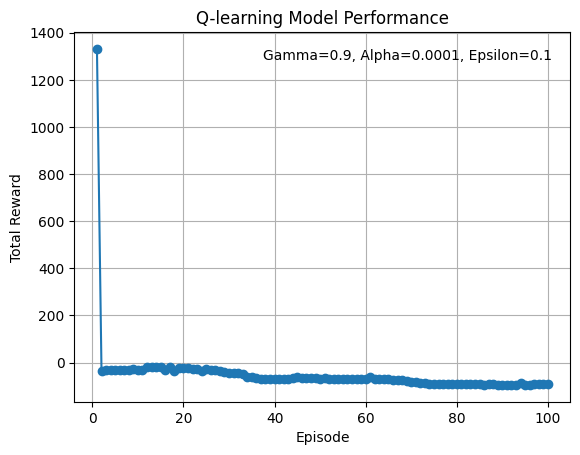

In [28]:
# Plot the episode rewards
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}, Epsilon={epsilon}'
plt.text(NUM_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()